In [36]:
import pandas as pd
from katlas.pssm import *
from matplotlib import pyplot as plt
from functools import partial

In [2]:
df = pd.read_csv('raw/psp_ks_dataset_2408.csv')

In [3]:
df['kin_uniprot'] = df.KIN_ACC_ID.str.split('-').str[0]

In [4]:
df.kin_uniprot.value_counts()

kin_uniprot
P17612    1105
P06493     816
P68400     799
P17252     772
P12931     753
          ... 
O54988       1
Q9BRS2       1
Q80X41       1
O55098       1
Q5U4C9       1
Name: count, Length: 834, dtype: int64

In [5]:
nonhuman = (df.KIN_ORGANISM.value_counts()>13)[lambda x: x].index[1:]

In [6]:
nonhuman

Index(['mouse', 'rat', 'cow', 'chicken', 'rabbit', 'pig', 'herpesvirus'], dtype='object', name='KIN_ORGANISM')

In [7]:
df = df[df.KIN_ORGANISM.isin(nonhuman)]

In [8]:
df.shape

(4759, 17)

In [9]:
df['sub_uniprot']=df.SUB_ACC_ID.str.split('-').str[0]

In [10]:
df['sub_site'] = df.sub_uniprot+"_"+df.SUB_MOD_RSD

In [11]:
df.shape

(4759, 19)

In [12]:
# remove sub site duplicates for each kinase
df = df.drop_duplicates(subset=['kin_uniprot','sub_site'])

In [13]:
df.shape

(4734, 19)

In [14]:
kin_idxs = (df.kin_uniprot.value_counts()>=30)[lambda x: x].index

In [15]:
pred_pspa=pd.read_parquet('raw/pred_new_pspa.parquet')
pred_cddm=pd.read_parquet('raw/pred_new_cddm.parquet')

In [16]:
idxs = pred_pspa.index.str.split('_').str[0]

In [17]:
idxs.isin(df.kin_uniprot).sum()

np.int64(322)

In [18]:
idxs.isin(kin_idxs).sum()

np.int64(34)

In [19]:
df['site_seq'] = df['SITE_+/-7_AA']

In [21]:
psp_nonhuman = get_cluster_pssms(df,cluster_col = 'kin_uniprot',count_thr=30)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:00<00:00, 706.09it/s]


In [22]:
idx_overlap = list(set(idxs)&set(psp_nonhuman.index))

In [23]:
ori_index = pred_pspa.index

In [24]:
pred_pspa.index=pred_pspa.index.str.split('_').str[0]

In [25]:
pred_pspa = pred_pspa.loc[idx_overlap]
nonhuman_pspa = psp_nonhuman.loc[idx_overlap]

## Comopare the two

In [27]:
def score_df(target,pred,func):
    cols = list(set(target.columns)&set(pred.columns))
    distance = [func(target.loc[i,cols],pred.loc[i,cols]) for i in target.index]
    return pd.Series(distance,index=target.index)

In [28]:
jsd_df = partial(score_df,func=js_divergence_flat)

In [29]:
jsd_score = jsd_df(nonhuman_pspa,pred_pspa).sort_values()

In [32]:
pred_pspa,nonhuman_pspa = pred_pspa.align(nonhuman_pspa,join='inner')

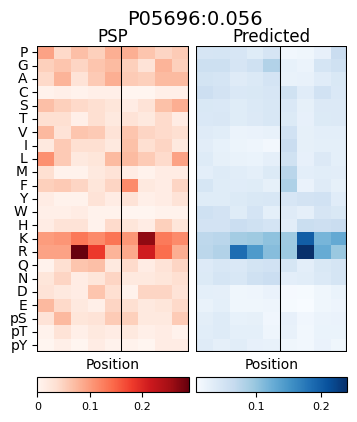

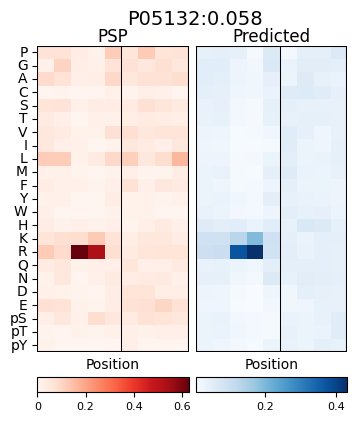

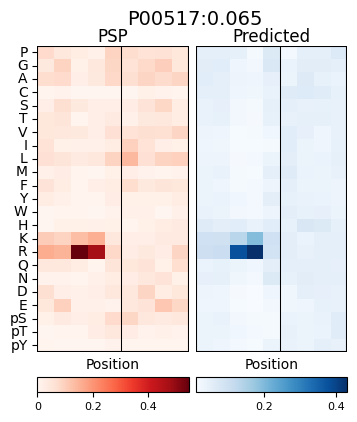

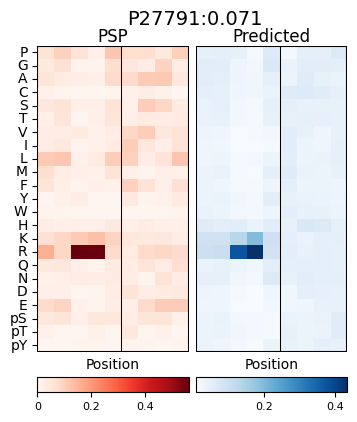

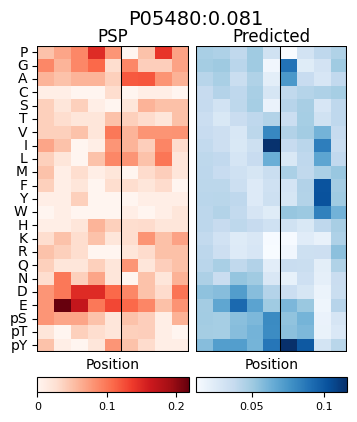

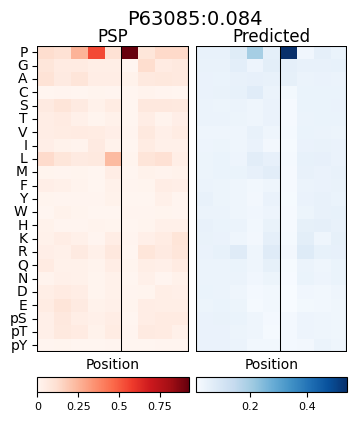

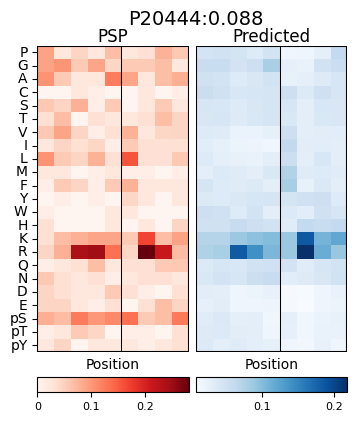

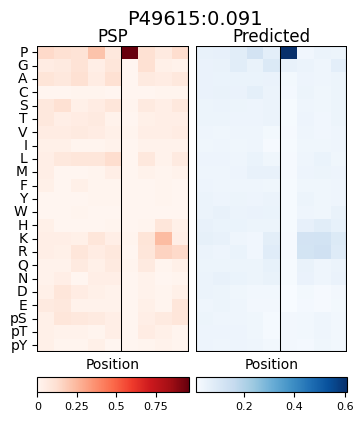

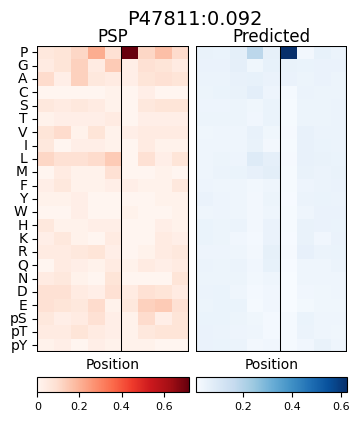

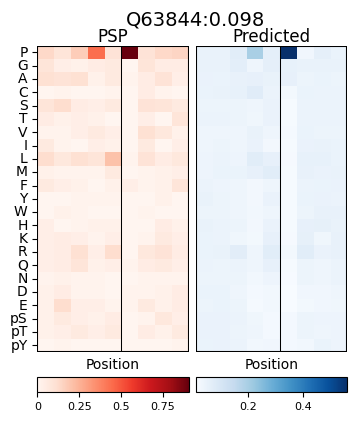

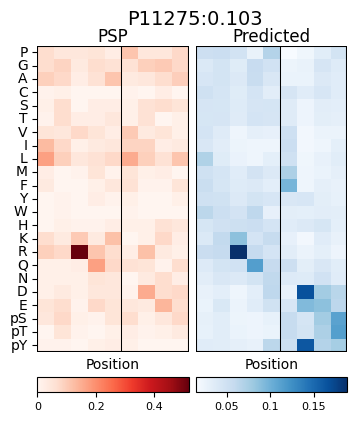

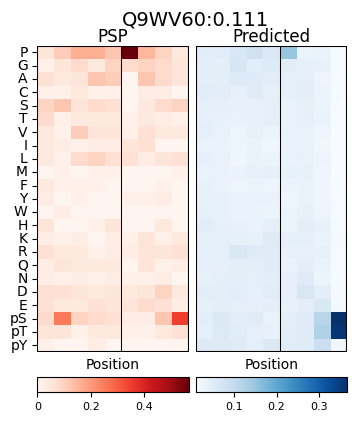

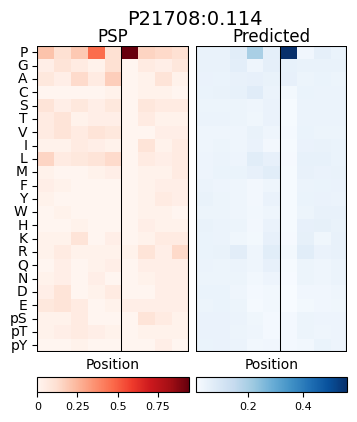

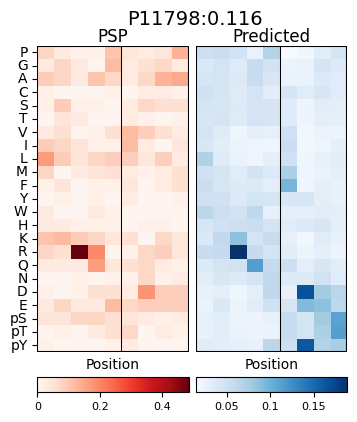

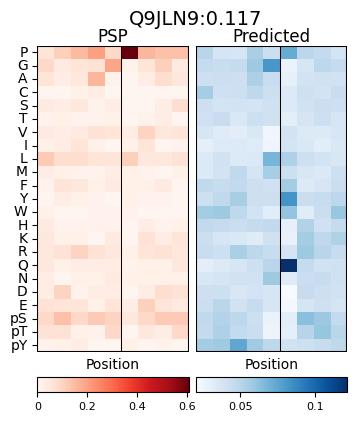

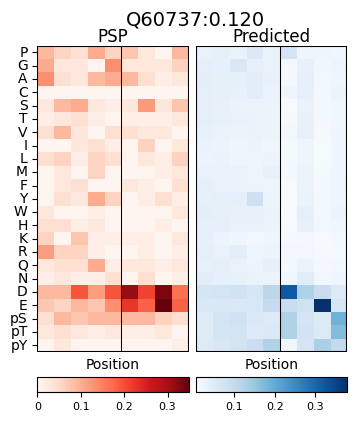

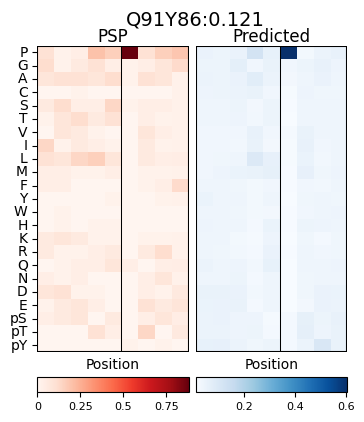

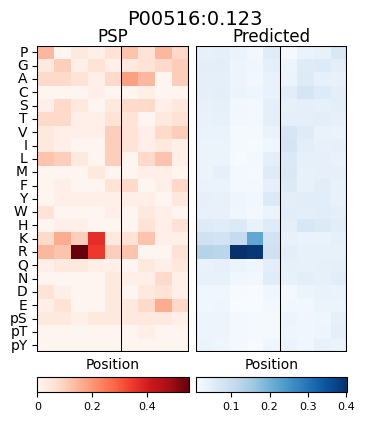

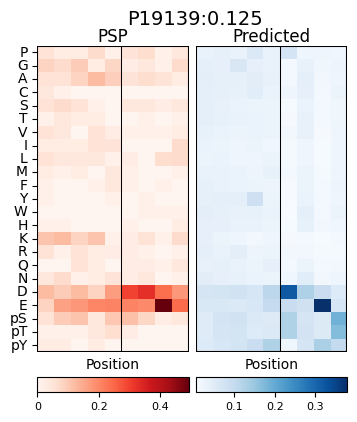

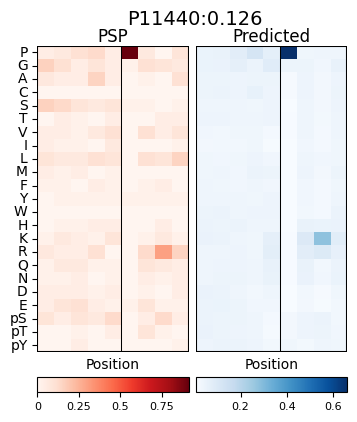

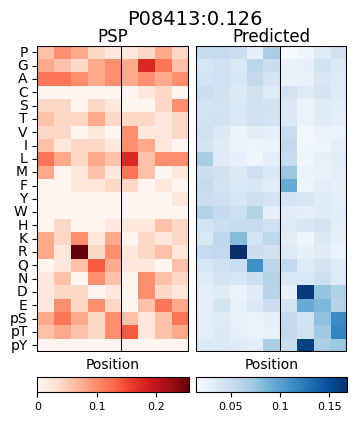

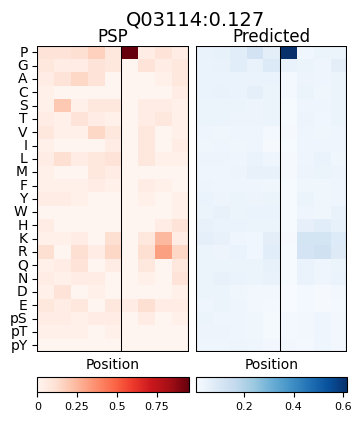

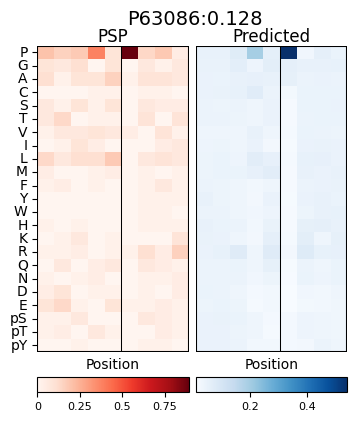

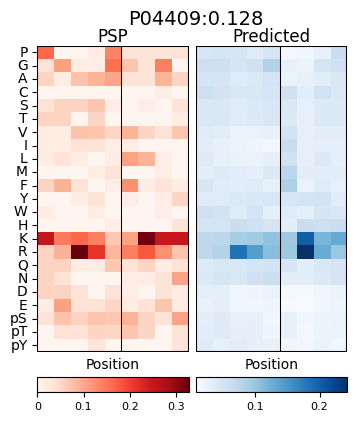

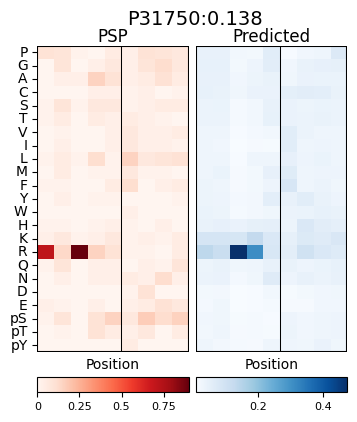

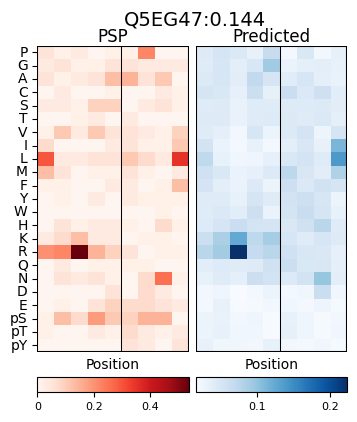

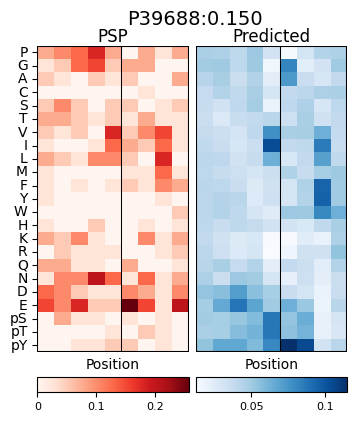

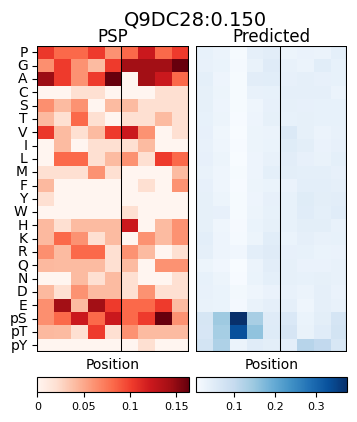

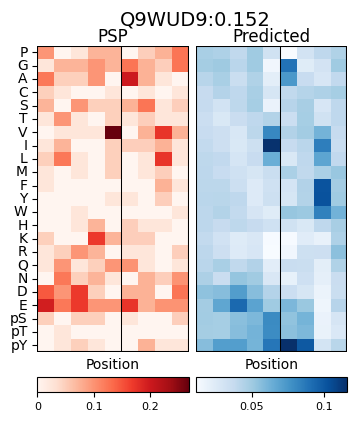

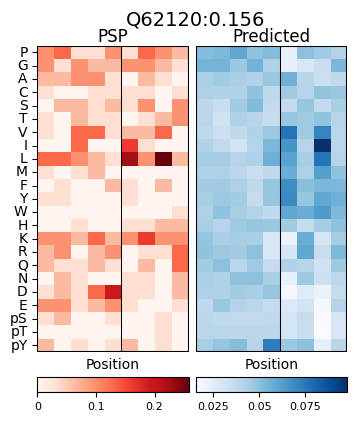

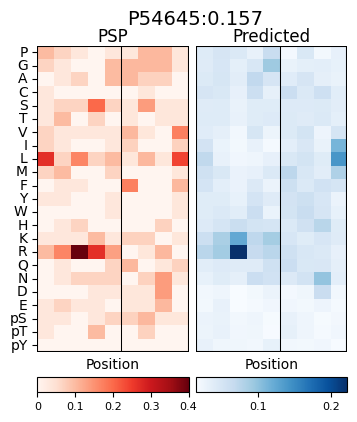

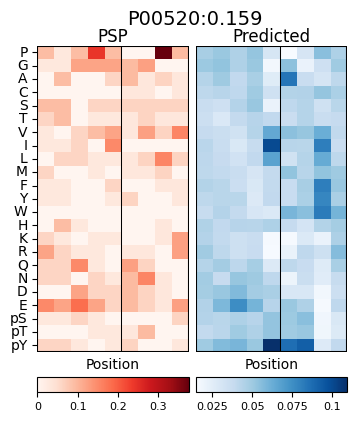

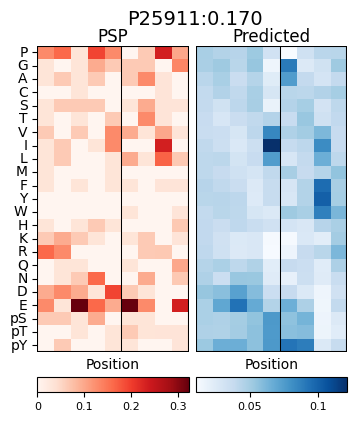

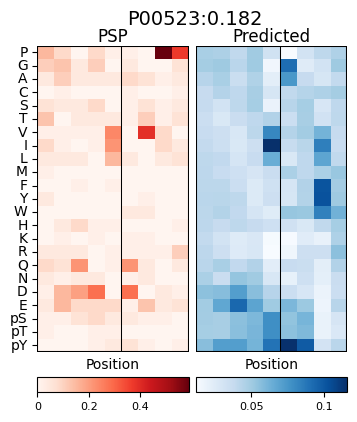

In [38]:
for idx,score in jsd_score.items():
    pssm1 = recover_pssm(nonhuman_pspa.loc[idx])
    pssm2 = recover_pssm(pred_pspa.loc[idx])
    
    plot_two_heatmaps(pssm1,pssm2,f'{idx}:{score:.3f}','PSP','Predicted',scale_01=False)
    plt.show()
    plt.close()
    # break